## Driving Range Prediction and Energy Consumption in EV

Analysis is done on a particular Electrical Vehicle model car-Volkswagen eGolf.

Understanding as a machine learning problem: 

1- Driving range prediction is a regression problem.

2- Models need not be time-constrained.

3- Some form of Interpretability of the predicted driving range is needed.

4- MAE and R-squared were used for measuring the performance of the model.

### Data

a public dataset 

#### Libraries from Pyton

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
input_path = 'input_dataset/volkswagen_e_golf.csv'
df = pd.read_csv(input_path)

#### Sample of data

In [3]:
df.head()

,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
0,Volkswagen,Golf,e-Golf,85,08.02.2019,80,NaN,Electricity,Winter tires,0,0,1,Normal,17.8,0,1,53.0,1.0
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50,12.29,Electricity,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43,8.68,Electricity,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44,1.50,Electricity,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76,14.44,Electricity,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   manufacturer            3345 non-null   object 
 1   model                   3345 non-null   object 
 2   version                 3345 non-null   object 
 3   power(kW)               3345 non-null   int64  
 4   fuel_date               3345 non-null   object 
 5   trip_distance(km)       3344 non-null   object 
 6   quantity(kWh)           3344 non-null   float64
 7   fuel_type               3345 non-null   object 
 8   tire_type               3345 non-null   object 
 9   city                    3345 non-null   int64  
 10  motor_way               3345 non-null   int64  
 11  country_roads           3345 non-null   int64  
 12  driving_style           3345 non-null   object 
 13  consumption(kWh/100km)  3345 non-null   float64
 14  A/C                     3345 non-null   

#### Data Overview

“ecr_deviation,” : difference between the energy consumption rate recorded at each trip and the value announced by the manufacturer, which is stated as 16.8 kilowatts per hundred kilometers.

“a/c” : inside vehicle air-conditioning

“park_heating” is the car’s heating system
the useless columns, such as model and theversion of the vehicle, are eliminated and the “distance (km)” column is labeled as the target.

In [5]:
df['city'].value_counts()

1    2323
0    1022
Name: city, dtype: int64

In [6]:
df['motor_way'].value_counts()

1    2225
0    1120
Name: motor_way, dtype: int64

In [7]:
df['country_roads'].value_counts()

1    1963
0    1382
Name: country_roads, dtype: int64

In [8]:
df['A/C'].value_counts()

0    3195
1     150
Name: A/C, dtype: int64

In [9]:
df['park_heating'].value_counts()

0    2714
1     631
Name: park_heating, dtype: int64

trip_distance(km) is a numeric data type

city, motor_way, country_roads, A/C, park_heating are binomial data types can be converted to string types or can be remained as_it_is.

In [10]:
def converttype(value, default, t):
    if t == 'numeric':
        try:
            return float(value)
        except (ValueError,TypeError):
            return(default)
    if t == 'str':
        try:
            return str(value)
        except (ValueError, TypeError):
            return(defualt)
            
            

In [11]:
df['trip_distance(km)'] = df['trip_distance(km)'].map(lambda x : converttype(x, np.nan, 'numeric'))

In [12]:
df.dtypes

manufacturer               object
model                      object
version                    object
power(kW)                   int64
fuel_date                  object
trip_distance(km)         float64
quantity(kWh)             float64
fuel_type                  object
tire_type                  object
city                        int64
motor_way                   int64
country_roads               int64
driving_style              object
consumption(kWh/100km)    float64
A/C                         int64
park_heating                int64
avg_speed(km/h)           float64
ecr_deviation             float64
dtype: object

In [13]:
# Observing nonstandard data in Object variables

print("power")
display(df['power(kW)'].value_counts())

# manufacturer
print("Manufacturers")
display(df['manufacturer'].value_counts())

# models
print("Models")
display(df['model'].value_counts())

# versions
print("Versions")
display(df['version'].value_counts())

# fuel type
print("Fuel type")
display(df['fuel_type'].value_counts())

# type type
print("tire type")
display(df['tire_type'].value_counts())

# driving_style
print("driving_style")
display(df['driving_style'].value_counts())

power


85    3345
Name: power(kW), dtype: int64

Manufacturers


Volkswagen    3345
Name: manufacturer, dtype: int64

Models


Golf    3345
Name: model, dtype: int64

Versions


e-Golf    3345
Name: version, dtype: int64

Fuel type


Electricity    3345
Name: fuel_type, dtype: int64

tire type


Summer tires    1826
Winter tires    1519
Name: tire_type, dtype: int64

driving_style


Moderate    2334
Normal       912
Fast          99
Name: driving_style, dtype: int64

##### No Non-standard missing values found in object datatypes

In [14]:
# standard missing values
df.isnull().sum()[df.isnull().sum() > 0]

trip_distance(km)     4
quantity(kWh)         1
avg_speed(km/h)      13
dtype: int64

drop one record for quantity

In [15]:
# We cannot impute quantity (kWh) and there are only one missing value. We will drop that row.
df.drop(axis = 0, index = 0, inplace=True)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


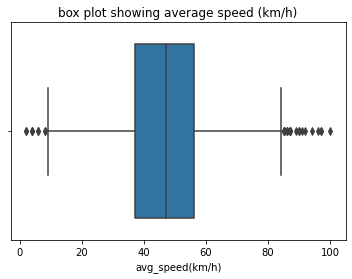

In [16]:
plt.title('box plot showing average speed (km/h)')
sns.boxplot(df['avg_speed(km/h)'])
plt.show()

In [17]:
df['avg_speed(km/h)'].describe()

count    3331.000000
mean       46.745392
std        16.273316
min         2.000000
25%        37.000000
50%        47.000000
75%        56.000000
max       100.000000
Name: avg_speed(km/h), dtype: float64

In [18]:
df['avg_speed(km/h)'].mode()

0    49.0
dtype: float64

In [19]:
null_ave_speed_df = df[df['avg_speed(km/h)'].isnull()]

In [20]:
null_ave_speed_df.index

Int64Index([739, 795, 819, 895, 897, 923, 924, 938, 939, 2337, 2594, 2795,
            3228],
           dtype='int64')

In [23]:
for index, row in df.iterrows() :
    if index not in null_ave_speed_df.index : 
        a = 10
    else :
        mean = df[
            (df['city'] == row['city']) &
            (df['motor_way'] == row['motor_way']) &
            (df['country_roads'] == row['country_roads']) &
            (df['driving_style'] == row['driving_style'])
        ]['avg_speed(km/h)'].mean()
        median = df[
            (df['city'] == row['city']) &
            (df['motor_way'] == row['motor_way']) &
            (df['country_roads'] == row['country_roads']) &
            (df['driving_style'] == row['driving_style'])
        ]['avg_speed(km/h)'].median()

     
        if(abs(mean - median) > 5) :
            df.loc[index, 'avg_speed(km/h)'] = median
        else :
            df.loc[index, 'avg_speed(km/h)'] = mean

In [24]:
# Check the missing values again.
df.isnull().sum()[df.isnull().sum() > 0]

trip_distance(km)    4
dtype: int64

In [25]:
target_null_rows_df = df[df['trip_distance(km)'].isnull()]

df.drop(axis = 0, index = target_null_rows_df.index, inplace=True)

In [26]:
# Check the missing values again.
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

### Prepare Stage0 Dataset for by removing unwanted features

In [27]:
unwanted_features = ['manufacturer','model','version','power(kW)', 'fuel_type','fuel_date']
df.drop(axis= 1, columns= unwanted_features,inplace=True)

In [28]:
df.head()

,trip_distance(km),quantity(kWh),tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
1,50.0,12.29,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,43.0,8.68,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,44.0,1.50,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,76.0,14.44,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2
5,15.0,6.84,Winter tires,1,0,0,Normal,16.1,0,1,23.0,-0.7


In [29]:
df.to_csv('processed_stage0.csv')

In [30]:
# drop the tripdistance column in this df
target_null_rows_df.drop(columns = ['trip_distance(km)','manufacturer', 'model', 'version', 'power(kW)', 'fuel_type', 'fuel_date'], inplace=True)
target_null_rows_df.to_csv('test_additional_raw_stage0_data.csv', index = False)

/Users/elham/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
